# Environment

In [1]:
import os
from pprint import pprint
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode

import medmnist
from medmnist import INFO

import src.medmnist_dataset as md
from src.architectures import architecture, VisionTransformer
from src.train import train_loop, EarlyStopping

In [2]:
# Set the global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
# Get CWD
CWD = os.getcwd()

In [4]:
print(medmnist.__version__)

3.0.2


# Data

## Data Download

In [5]:
avaliable_datasets = ["pathmnist", "dermamnist", \
                    "octmnist", "pneumoniamnist", "breastmnist", \
                    "bloodmnist", "tissuemnist", "organamnist", \
                    "organcmnist", "organsmnist"] # "retinamnist", "chestmnist"]

In [6]:
for dataset_name in avaliable_datasets:
    
    info = INFO[dataset_name]
    print(f"-"*100)
    print(f"Dataset: {dataset_name}")
    print(f"Python: {info['python_class']}")
    print(f"Task: {info['task']}")
    print(f"Number of classes: {len(info['label'])}")
    print(f"Channels: {info['n_channels']}")
    print("Classes:")
    pprint(info['label'])

----------------------------------------------------------------------------------------------------
Dataset: pathmnist
Python: PathMNIST
Task: multi-class
Number of classes: 9
Channels: 3
Classes:
{'0': 'adipose',
 '1': 'background',
 '2': 'debris',
 '3': 'lymphocytes',
 '4': 'mucus',
 '5': 'smooth muscle',
 '6': 'normal colon mucosa',
 '7': 'cancer-associated stroma',
 '8': 'colorectal adenocarcinoma epithelium'}
----------------------------------------------------------------------------------------------------
Dataset: dermamnist
Python: DermaMNIST
Task: multi-class
Number of classes: 7
Channels: 3
Classes:
{'0': 'actinic keratoses and intraepithelial carcinoma',
 '1': 'basal cell carcinoma',
 '2': 'benign keratosis-like lesions',
 '3': 'dermatofibroma',
 '4': 'melanoma',
 '5': 'melanocytic nevi',
 '6': 'vascular lesions'}
----------------------------------------------------------------------------------------------------
Dataset: octmnist
Python: OCTMNIST
Task: multi-class
Number 

In [7]:
image_size = 28 # 28, 64, 128 or 256
datasets_path = os.path.join(CWD, "datasets", str(image_size))
os.makedirs(datasets_path, exist_ok=True)

md.download(avaliable_datasets, datasets_path, image_size)

File d:\AI\med-mnist\datasets\28\pathmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\dermamnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\octmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\pneumoniamnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\breastmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\bloodmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\tissuemnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\organamnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\organcmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\organsmnist_28.npz already exists. Skipping download.


## Dataset Unification

In [8]:
organ_datasets = ["organamnist", "organcmnist", "organsmnist"] # These are the same - have the same classes

md.unify_data(
    organ_datasets,
    are_unique_classes      = False,
    image_size              = image_size,
    datasets_path           = datasets_path,
    save_path               = datasets_path,
    filename                = f"organs_{image_size}"
);

File d:\AI\med-mnist\datasets\28\organs_28.npz already exists.


In [9]:
new_avaliable_datasets = ["organs", "pathmnist", "dermamnist", "octmnist", "pneumoniamnist", \
                            "breastmnist", "bloodmnist", "tissuemnist"]

md.unify_data(
    new_avaliable_datasets,
    are_unique_classes      = True,
    image_size              = image_size,
    datasets_path           = datasets_path,
    save_path               = datasets_path,
    filename                = f"unified_{image_size}"
);

File d:\AI\med-mnist\datasets\28\unified_28.npz already exists.


## Dataset

In [10]:
transform = v2.Compose(
    [
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
)

# Training augmentations
augmentation = v2.Compose(
    [
        transform,
        v2.RandomHorizontalFlip(p=0.5),
        v2.Pad(round(image_size/10), padding_mode="reflect"),
        v2.RandomRotation(degrees=10, interpolation=InterpolationMode.BILINEAR),
        v2.CenterCrop(size=(image_size, image_size))
    ]
)

In [11]:
unified_dataset_path = os.path.join(datasets_path, f"unified_{image_size}.npz")

train_dataset = md.NPZDataset(unified_dataset_path, split="train", transform=augmentation)
validation_dataset = md.NPZDataset(unified_dataset_path, split="val", transform=transform)

## Data Loader

In [12]:
batch_size = 256
num_workers = 4

In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size          =batch_size, 
    shuffle             =True,
    num_workers         =num_workers,
    prefetch_factor     =10,
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size          =batch_size, 
    shuffle             =False,
    num_workers         =num_workers,
    prefetch_factor     =10,
)

### Test Data Loader

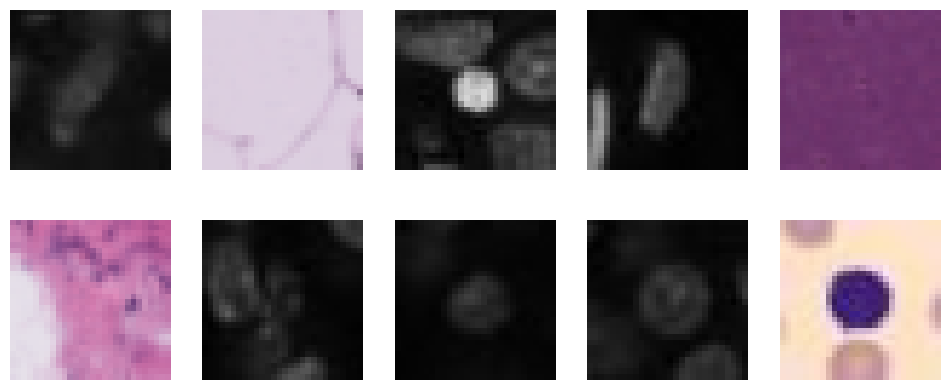

In [14]:
# Get one batch from train_loader
batch = next(iter(train_loader))
images, labels = batch  # Unpack batch

# # Denormalize for visualization
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # Shape (C, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)

# Convert images back to [0, 1] range for visualization
images = images * std + mean  
images = torch.clamp(images, 0, 1)  # Ensure values stay in range

# Plot some images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))  # Grid 2x5
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) → (H, W, C)
    ax.imshow(img)
    ax.axis("off")

plt.show()

# Training

## Parameters

In [15]:
epochs          =50
arch            ="vit"

optimizer_name  ="Adam"
lr              =1e-4
momentum        =1
weight_decay    =1e-3

stat_to_track   ="val_loss" # "loss" "acc" "val_loss" "lr"
mode            ="min" # "min" "max"
patience        =4
delta           =5e-2
delay           = 8

In [16]:
patch_size      =4
depth           =8
num_heads       =8
mlp_ratio       =4

## Model

In [17]:
model = VisionTransformer(
    image_size          =image_size,
    patch_size          =patch_size,
    in_channels         =3, 
    num_classes         =51,
    projection_dim      =patch_size*patch_size*3,
    depth               =depth,
    num_heads           =num_heads,
    mlp_ratio           =mlp_ratio,
    dropout             =0.5
)

In [18]:
models_dir_path = os.path.join(CWD, "models")
os.makedirs(models_dir_path, exist_ok=True)

model_save_path = os.path.join(models_dir_path, f"{arch}_d{depth}_h{num_heads}_mlr{mlp_ratio}.pth")

In [19]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer selection
if optimizer_name == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


# Initialize the scheduler
# Uncomment the scheduler you want to use:
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Decreases LR by gamma every step_size epochs
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Adjusts LR using cosine annealing over epochs


# Early stopping
stop_fn = EarlyStopping(
    stat_to_track       =stat_to_track,
    mode                =mode,
    patience            =patience,
    delta               =delta,
    delay               =delay,
    save_path           =model_save_path
)

train_loop(
    model,
    criterion           =criterion,
    optimizer           =optimizer,
    scheduler           =scheduler,
    epochs              =epochs,
    train_loader        =train_loader,
    validation_loader   =validation_loader,
    device              =device,
    stop_fn             =stop_fn
)

stopping_report = stop_fn.report()

# If the model was not stopped by EarlyStopping, save it
if not stopping_report:
    torch.save(model.state_dict(), model_save_path)
else:
    for key in stopping_report:
        print(f"{key}: {stopping_report[key]}")

 10/50:   0%|          | 0/1714 [00:31<?, ? batch/s]


KeyboardInterrupt: 